In [1]:
# Imports
import torch
import torchvision
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.nn.init as init    # For weight initializations
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import (
    DataLoader,
    # Dataset
)  # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
from tqdm import tqdm # For progress bars 
import matplotlib.pyplot as plt # For graphing  
import numpy as np  # For graphing  
import pandas as pd     # For data frames
import seaborn as sns   # For graphing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


In [2]:
# Hyperparameters
learning_rate = 1e-3
batch_size = 12000
num_epoches = 5

In [3]:
# Get MNIST data
train_ds = datasets.MNIST(
    root="dataset/", train=True, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)

test_ds = datasets.MNIST(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)

In [4]:
class StandardFeedforwardNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(28**2, 392)
        self.Matrix2 = nn.Linear(392, 196)
        self.Matrix3 = nn.Linear(196, 10)

        init.kaiming_uniform_(self.Matrix1.weight, mode="fan_in", nonlinearity="relu")
        init.kaiming_uniform_(self.Matrix2.weight, mode="fan_in", nonlinearity="relu") 
        init.kaiming_uniform_(self.Matrix3.weight, mode="fan_in", nonlinearity="relu")        

        self.R = nn.ReLU()

    def forward(self,x):
        x = x.view(-1,28**2)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.R(self.Matrix3(x))

        return x.squeeze()

In [5]:
# Check parameter matrix sizes
def print_parameter_info(model):
    for name, param in model.named_parameters():
        print(name)
        print(type(param), param.size())

In [6]:
# Train Network
def train_network(device, num_epoches, train_loader, model, criterion, optimizer):
    for epoch in range(num_epoches):
        losses = []

        for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets)

            losses.append(loss.item())
            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

        # print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")

In [7]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        accuracy = float(num_correct)/float(num_samples)
        print(f"Got {num_correct} / {num_samples} with accuracy {accuracy*100:.2f}%")

    model.train()
    return accuracy

In [8]:
def run_trials(num_trainings):
  # Define model, loss, and optimizer 
  model = StandardFeedforwardNetwork()
  print_parameter_info(model)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  
  acc_dict = {}
  acc_dict[0] = 0

  # Loop for number of trainings
  for training in range(num_trainings):
    # Train network
    train_network(device, num_epoches, train_loader, model, criterion, optimizer)
    acc_dict[training + 1] = check_accuracy(test_loader, model)

    print(f"Row: {training + 1} | {list(acc_dict.values())}")

  # Plot graph of accuracies after the trial
  ypoints = np.array(list(acc_dict.values()))
  plt.xticks(np.arange(0, len(ypoints), 1.0))
  plt.xlabel("Number of trainings")
  plt.ylabel("Accuracy")
  plt.plot(ypoints)
  plt.show()

  return list(acc_dict.values())

--- NEW MODEL 0 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([196, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([196])
Matrix3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 196])
Matrix3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Checking accuracy on test data
Got 8005 / 10000 with accuracy 80.05%
Row: 1 | [0, 0.8005]


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Checking accuracy on test data
Got 8428 / 10000 with accuracy 84.28%
Row: 2 | [0, 0.8005, 0.8428]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 8550 / 10000 with accuracy 85.50%
Row: 3 | [0, 0.8005, 0.8428, 0.855]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 8648 / 10000 with accuracy 86.48%
Row: 4 | [0, 0.8005, 0.8428, 0.855, 0.8648]


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Checking accuracy on test data
Got 8716 / 10000 with accuracy 87.16%
Row: 5 | [0, 0.8005, 0.8428, 0.855, 0.8648, 0.8716]


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Checking accuracy on test data
Got 8751 / 10000 with accuracy 87.51%
Row: 6 | [0, 0.8005, 0.8428, 0.855, 0.8648, 0.8716, 0.8751]


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Checking accuracy on test data
Got 8773 / 10000 with accuracy 87.73%
Row: 7 | [0, 0.8005, 0.8428, 0.855, 0.8648, 0.8716, 0.8751, 0.8773]


100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


Checking accuracy on test data
Got 8791 / 10000 with accuracy 87.91%
Row: 8 | [0, 0.8005, 0.8428, 0.855, 0.8648, 0.8716, 0.8751, 0.8773, 0.8791]


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Checking accuracy on test data
Got 8801 / 10000 with accuracy 88.01%
Row: 9 | [0, 0.8005, 0.8428, 0.855, 0.8648, 0.8716, 0.8751, 0.8773, 0.8791, 0.8801]


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Checking accuracy on test data
Got 8819 / 10000 with accuracy 88.19%
Row: 10 | [0, 0.8005, 0.8428, 0.855, 0.8648, 0.8716, 0.8751, 0.8773, 0.8791, 0.8801, 0.8819]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 8824 / 10000 with accuracy 88.24%
Row: 11 | [0, 0.8005, 0.8428, 0.855, 0.8648, 0.8716, 0.8751, 0.8773, 0.8791, 0.8801, 0.8819, 0.8824]


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Checking accuracy on test data
Got 8845 / 10000 with accuracy 88.45%
Row: 12 | [0, 0.8005, 0.8428, 0.855, 0.8648, 0.8716, 0.8751, 0.8773, 0.8791, 0.8801, 0.8819, 0.8824, 0.8845]


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Checking accuracy on test data
Got 8834 / 10000 with accuracy 88.34%
Row: 13 | [0, 0.8005, 0.8428, 0.855, 0.8648, 0.8716, 0.8751, 0.8773, 0.8791, 0.8801, 0.8819, 0.8824, 0.8845, 0.8834]


100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


Checking accuracy on test data
Got 8844 / 10000 with accuracy 88.44%
Row: 14 | [0, 0.8005, 0.8428, 0.855, 0.8648, 0.8716, 0.8751, 0.8773, 0.8791, 0.8801, 0.8819, 0.8824, 0.8845, 0.8834, 0.8844]


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Checking accuracy on test data
Got 8843 / 10000 with accuracy 88.43%
Row: 15 | [0, 0.8005, 0.8428, 0.855, 0.8648, 0.8716, 0.8751, 0.8773, 0.8791, 0.8801, 0.8819, 0.8824, 0.8845, 0.8834, 0.8844, 0.8843]


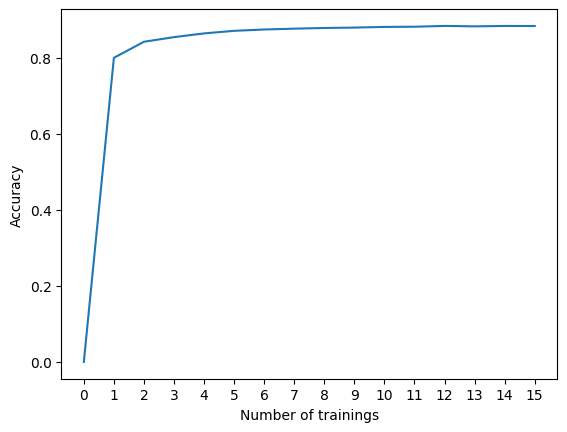

--- NEW MODEL 1 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([196, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([196])
Matrix3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 196])
Matrix3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:15<00:00,  3.20s/it]


Checking accuracy on test data
Got 7446 / 10000 with accuracy 74.46%
Row: 1 | [0, 0.7446]


100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


Checking accuracy on test data
Got 7656 / 10000 with accuracy 76.56%
Row: 2 | [0, 0.7446, 0.7656]


100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


Checking accuracy on test data
Got 7763 / 10000 with accuracy 77.63%
Row: 3 | [0, 0.7446, 0.7656, 0.7763]


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Checking accuracy on test data
Got 7824 / 10000 with accuracy 78.24%
Row: 4 | [0, 0.7446, 0.7656, 0.7763, 0.7824]


100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


Checking accuracy on test data
Got 7845 / 10000 with accuracy 78.45%
Row: 5 | [0, 0.7446, 0.7656, 0.7763, 0.7824, 0.7845]


100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


Checking accuracy on test data
Got 7863 / 10000 with accuracy 78.63%
Row: 6 | [0, 0.7446, 0.7656, 0.7763, 0.7824, 0.7845, 0.7863]


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Checking accuracy on test data
Got 7873 / 10000 with accuracy 78.73%
Row: 7 | [0, 0.7446, 0.7656, 0.7763, 0.7824, 0.7845, 0.7863, 0.7873]


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Checking accuracy on test data
Got 7881 / 10000 with accuracy 78.81%
Row: 8 | [0, 0.7446, 0.7656, 0.7763, 0.7824, 0.7845, 0.7863, 0.7873, 0.7881]


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Checking accuracy on test data
Got 7885 / 10000 with accuracy 78.85%
Row: 9 | [0, 0.7446, 0.7656, 0.7763, 0.7824, 0.7845, 0.7863, 0.7873, 0.7881, 0.7885]


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Checking accuracy on test data
Got 7881 / 10000 with accuracy 78.81%
Row: 10 | [0, 0.7446, 0.7656, 0.7763, 0.7824, 0.7845, 0.7863, 0.7873, 0.7881, 0.7885, 0.7881]


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Checking accuracy on test data
Got 7883 / 10000 with accuracy 78.83%
Row: 11 | [0, 0.7446, 0.7656, 0.7763, 0.7824, 0.7845, 0.7863, 0.7873, 0.7881, 0.7885, 0.7881, 0.7883]


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Checking accuracy on test data
Got 7885 / 10000 with accuracy 78.85%
Row: 12 | [0, 0.7446, 0.7656, 0.7763, 0.7824, 0.7845, 0.7863, 0.7873, 0.7881, 0.7885, 0.7881, 0.7883, 0.7885]


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Checking accuracy on test data
Got 7888 / 10000 with accuracy 78.88%
Row: 13 | [0, 0.7446, 0.7656, 0.7763, 0.7824, 0.7845, 0.7863, 0.7873, 0.7881, 0.7885, 0.7881, 0.7883, 0.7885, 0.7888]


100%|██████████| 5/5 [00:15<00:00,  3.20s/it]


Checking accuracy on test data
Got 7885 / 10000 with accuracy 78.85%
Row: 14 | [0, 0.7446, 0.7656, 0.7763, 0.7824, 0.7845, 0.7863, 0.7873, 0.7881, 0.7885, 0.7881, 0.7883, 0.7885, 0.7888, 0.7885]


100%|██████████| 5/5 [00:16<00:00,  3.31s/it]


Checking accuracy on test data
Got 7895 / 10000 with accuracy 78.95%
Row: 15 | [0, 0.7446, 0.7656, 0.7763, 0.7824, 0.7845, 0.7863, 0.7873, 0.7881, 0.7885, 0.7881, 0.7883, 0.7885, 0.7888, 0.7885, 0.7895]


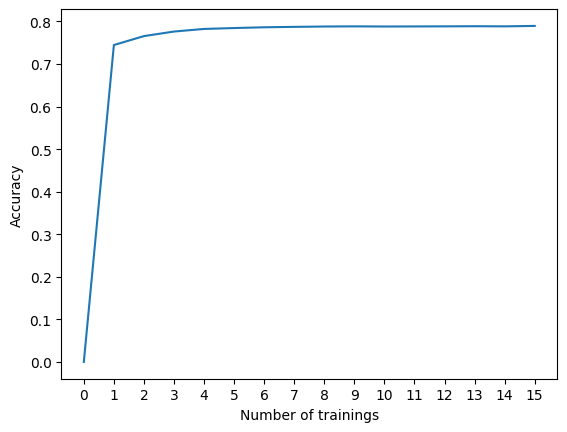

--- NEW MODEL 2 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([196, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([196])
Matrix3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 196])
Matrix3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:16<00:00,  3.22s/it]


Checking accuracy on test data
Got 9168 / 10000 with accuracy 91.68%
Row: 1 | [0, 0.9168]


100%|██████████| 5/5 [00:16<00:00,  3.32s/it]


Checking accuracy on test data
Got 9452 / 10000 with accuracy 94.52%
Row: 2 | [0, 0.9168, 0.9452]


100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


Checking accuracy on test data
Got 9580 / 10000 with accuracy 95.80%
Row: 3 | [0, 0.9168, 0.9452, 0.958]


100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


Checking accuracy on test data
Got 9650 / 10000 with accuracy 96.50%
Row: 4 | [0, 0.9168, 0.9452, 0.958, 0.965]


100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


Checking accuracy on test data
Got 9701 / 10000 with accuracy 97.01%
Row: 5 | [0, 0.9168, 0.9452, 0.958, 0.965, 0.9701]


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Checking accuracy on test data
Got 9719 / 10000 with accuracy 97.19%
Row: 6 | [0, 0.9168, 0.9452, 0.958, 0.965, 0.9701, 0.9719]


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Checking accuracy on test data
Got 9744 / 10000 with accuracy 97.44%
Row: 7 | [0, 0.9168, 0.9452, 0.958, 0.965, 0.9701, 0.9719, 0.9744]


100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


Checking accuracy on test data
Got 9766 / 10000 with accuracy 97.66%
Row: 8 | [0, 0.9168, 0.9452, 0.958, 0.965, 0.9701, 0.9719, 0.9744, 0.9766]


100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


Checking accuracy on test data
Got 9774 / 10000 with accuracy 97.74%
Row: 9 | [0, 0.9168, 0.9452, 0.958, 0.965, 0.9701, 0.9719, 0.9744, 0.9766, 0.9774]


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Checking accuracy on test data
Got 9786 / 10000 with accuracy 97.86%
Row: 10 | [0, 0.9168, 0.9452, 0.958, 0.965, 0.9701, 0.9719, 0.9744, 0.9766, 0.9774, 0.9786]


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Checking accuracy on test data
Got 9786 / 10000 with accuracy 97.86%
Row: 11 | [0, 0.9168, 0.9452, 0.958, 0.965, 0.9701, 0.9719, 0.9744, 0.9766, 0.9774, 0.9786, 0.9786]


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Checking accuracy on test data
Got 9791 / 10000 with accuracy 97.91%
Row: 12 | [0, 0.9168, 0.9452, 0.958, 0.965, 0.9701, 0.9719, 0.9744, 0.9766, 0.9774, 0.9786, 0.9786, 0.9791]


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Checking accuracy on test data
Got 9791 / 10000 with accuracy 97.91%
Row: 13 | [0, 0.9168, 0.9452, 0.958, 0.965, 0.9701, 0.9719, 0.9744, 0.9766, 0.9774, 0.9786, 0.9786, 0.9791, 0.9791]


100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


Checking accuracy on test data
Got 9796 / 10000 with accuracy 97.96%
Row: 14 | [0, 0.9168, 0.9452, 0.958, 0.965, 0.9701, 0.9719, 0.9744, 0.9766, 0.9774, 0.9786, 0.9786, 0.9791, 0.9791, 0.9796]


100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


Checking accuracy on test data
Got 9798 / 10000 with accuracy 97.98%
Row: 15 | [0, 0.9168, 0.9452, 0.958, 0.965, 0.9701, 0.9719, 0.9744, 0.9766, 0.9774, 0.9786, 0.9786, 0.9791, 0.9791, 0.9796, 0.9798]


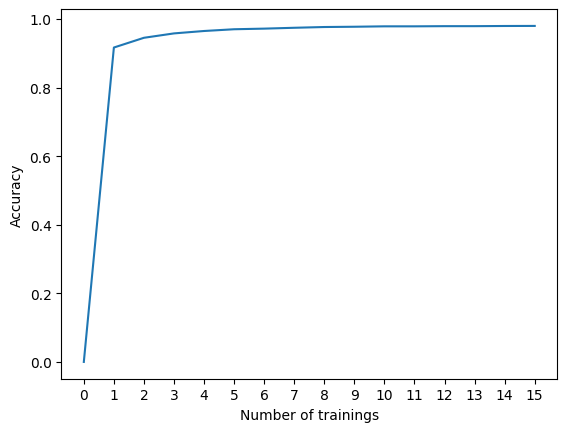

--- NEW MODEL 3 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([196, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([196])
Matrix3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 196])
Matrix3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Checking accuracy on test data
Got 9177 / 10000 with accuracy 91.77%
Row: 1 | [0, 0.9177]


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Checking accuracy on test data
Got 9457 / 10000 with accuracy 94.57%
Row: 2 | [0, 0.9177, 0.9457]


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Checking accuracy on test data
Got 9583 / 10000 with accuracy 95.83%
Row: 3 | [0, 0.9177, 0.9457, 0.9583]


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Checking accuracy on test data
Got 9650 / 10000 with accuracy 96.50%
Row: 4 | [0, 0.9177, 0.9457, 0.9583, 0.965]


100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


Checking accuracy on test data
Got 9698 / 10000 with accuracy 96.98%
Row: 5 | [0, 0.9177, 0.9457, 0.9583, 0.965, 0.9698]


100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


Checking accuracy on test data
Got 9730 / 10000 with accuracy 97.30%
Row: 6 | [0, 0.9177, 0.9457, 0.9583, 0.965, 0.9698, 0.973]


100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


Checking accuracy on test data
Got 9754 / 10000 with accuracy 97.54%
Row: 7 | [0, 0.9177, 0.9457, 0.9583, 0.965, 0.9698, 0.973, 0.9754]


100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


Checking accuracy on test data
Got 9762 / 10000 with accuracy 97.62%
Row: 8 | [0, 0.9177, 0.9457, 0.9583, 0.965, 0.9698, 0.973, 0.9754, 0.9762]


100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


Checking accuracy on test data
Got 9780 / 10000 with accuracy 97.80%
Row: 9 | [0, 0.9177, 0.9457, 0.9583, 0.965, 0.9698, 0.973, 0.9754, 0.9762, 0.978]


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Checking accuracy on test data
Got 9777 / 10000 with accuracy 97.77%
Row: 10 | [0, 0.9177, 0.9457, 0.9583, 0.965, 0.9698, 0.973, 0.9754, 0.9762, 0.978, 0.9777]


100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


Checking accuracy on test data
Got 9786 / 10000 with accuracy 97.86%
Row: 11 | [0, 0.9177, 0.9457, 0.9583, 0.965, 0.9698, 0.973, 0.9754, 0.9762, 0.978, 0.9777, 0.9786]


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Checking accuracy on test data
Got 9786 / 10000 with accuracy 97.86%
Row: 12 | [0, 0.9177, 0.9457, 0.9583, 0.965, 0.9698, 0.973, 0.9754, 0.9762, 0.978, 0.9777, 0.9786, 0.9786]


100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


Checking accuracy on test data
Got 9784 / 10000 with accuracy 97.84%
Row: 13 | [0, 0.9177, 0.9457, 0.9583, 0.965, 0.9698, 0.973, 0.9754, 0.9762, 0.978, 0.9777, 0.9786, 0.9786, 0.9784]


100%|██████████| 5/5 [00:16<00:00,  3.20s/it]


Checking accuracy on test data
Got 9790 / 10000 with accuracy 97.90%
Row: 14 | [0, 0.9177, 0.9457, 0.9583, 0.965, 0.9698, 0.973, 0.9754, 0.9762, 0.978, 0.9777, 0.9786, 0.9786, 0.9784, 0.979]


100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


Checking accuracy on test data
Got 9788 / 10000 with accuracy 97.88%
Row: 15 | [0, 0.9177, 0.9457, 0.9583, 0.965, 0.9698, 0.973, 0.9754, 0.9762, 0.978, 0.9777, 0.9786, 0.9786, 0.9784, 0.979, 0.9788]


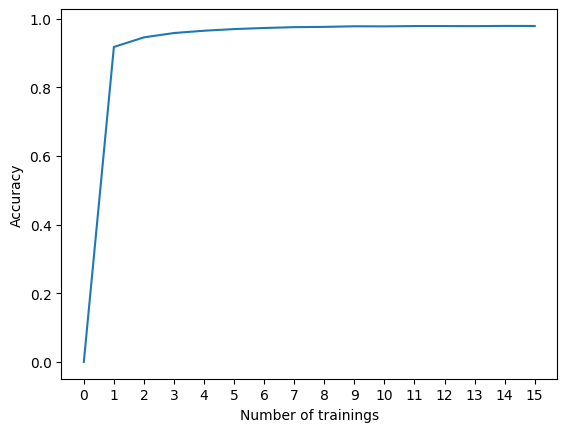

--- NEW MODEL 4 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([196, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([196])
Matrix3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 196])
Matrix3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:16<00:00,  3.23s/it]


Checking accuracy on test data
Got 9044 / 10000 with accuracy 90.44%
Row: 1 | [0, 0.9044]


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Checking accuracy on test data
Got 9397 / 10000 with accuracy 93.97%
Row: 2 | [0, 0.9044, 0.9397]


100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


Checking accuracy on test data
Got 9551 / 10000 with accuracy 95.51%
Row: 3 | [0, 0.9044, 0.9397, 0.9551]


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Checking accuracy on test data
Got 9628 / 10000 with accuracy 96.28%
Row: 4 | [0, 0.9044, 0.9397, 0.9551, 0.9628]


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Checking accuracy on test data
Got 9670 / 10000 with accuracy 96.70%
Row: 5 | [0, 0.9044, 0.9397, 0.9551, 0.9628, 0.967]


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Checking accuracy on test data
Got 9703 / 10000 with accuracy 97.03%
Row: 6 | [0, 0.9044, 0.9397, 0.9551, 0.9628, 0.967, 0.9703]


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Checking accuracy on test data
Got 9729 / 10000 with accuracy 97.29%
Row: 7 | [0, 0.9044, 0.9397, 0.9551, 0.9628, 0.967, 0.9703, 0.9729]


100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


Checking accuracy on test data
Got 9758 / 10000 with accuracy 97.58%
Row: 8 | [0, 0.9044, 0.9397, 0.9551, 0.9628, 0.967, 0.9703, 0.9729, 0.9758]


100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


Checking accuracy on test data
Got 9762 / 10000 with accuracy 97.62%
Row: 9 | [0, 0.9044, 0.9397, 0.9551, 0.9628, 0.967, 0.9703, 0.9729, 0.9758, 0.9762]


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Checking accuracy on test data
Got 9769 / 10000 with accuracy 97.69%
Row: 10 | [0, 0.9044, 0.9397, 0.9551, 0.9628, 0.967, 0.9703, 0.9729, 0.9758, 0.9762, 0.9769]


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Checking accuracy on test data
Got 9770 / 10000 with accuracy 97.70%
Row: 11 | [0, 0.9044, 0.9397, 0.9551, 0.9628, 0.967, 0.9703, 0.9729, 0.9758, 0.9762, 0.9769, 0.977]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 9779 / 10000 with accuracy 97.79%
Row: 12 | [0, 0.9044, 0.9397, 0.9551, 0.9628, 0.967, 0.9703, 0.9729, 0.9758, 0.9762, 0.9769, 0.977, 0.9779]


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Checking accuracy on test data
Got 9779 / 10000 with accuracy 97.79%
Row: 13 | [0, 0.9044, 0.9397, 0.9551, 0.9628, 0.967, 0.9703, 0.9729, 0.9758, 0.9762, 0.9769, 0.977, 0.9779, 0.9779]


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Checking accuracy on test data
Got 9780 / 10000 with accuracy 97.80%
Row: 14 | [0, 0.9044, 0.9397, 0.9551, 0.9628, 0.967, 0.9703, 0.9729, 0.9758, 0.9762, 0.9769, 0.977, 0.9779, 0.9779, 0.978]


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Checking accuracy on test data
Got 9789 / 10000 with accuracy 97.89%
Row: 15 | [0, 0.9044, 0.9397, 0.9551, 0.9628, 0.967, 0.9703, 0.9729, 0.9758, 0.9762, 0.9769, 0.977, 0.9779, 0.9779, 0.978, 0.9789]


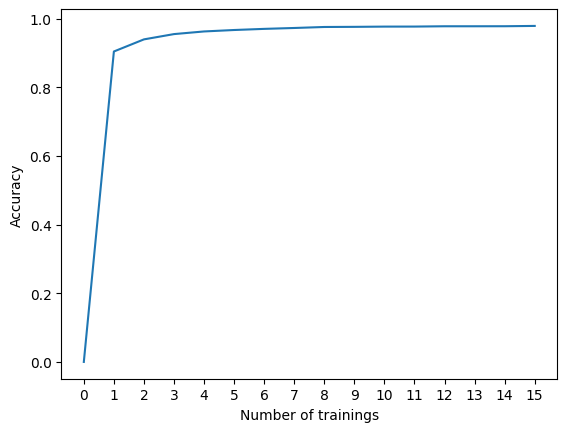

--- NEW MODEL 5 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([196, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([196])
Matrix3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 196])
Matrix3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Checking accuracy on test data
Got 9062 / 10000 with accuracy 90.62%
Row: 1 | [0, 0.9062]


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Checking accuracy on test data
Got 9434 / 10000 with accuracy 94.34%
Row: 2 | [0, 0.9062, 0.9434]


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Checking accuracy on test data
Got 9560 / 10000 with accuracy 95.60%
Row: 3 | [0, 0.9062, 0.9434, 0.956]


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Checking accuracy on test data
Got 9643 / 10000 with accuracy 96.43%
Row: 4 | [0, 0.9062, 0.9434, 0.956, 0.9643]


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Checking accuracy on test data
Got 9691 / 10000 with accuracy 96.91%
Row: 5 | [0, 0.9062, 0.9434, 0.956, 0.9643, 0.9691]


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Checking accuracy on test data
Got 9723 / 10000 with accuracy 97.23%
Row: 6 | [0, 0.9062, 0.9434, 0.956, 0.9643, 0.9691, 0.9723]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 9752 / 10000 with accuracy 97.52%
Row: 7 | [0, 0.9062, 0.9434, 0.956, 0.9643, 0.9691, 0.9723, 0.9752]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 9773 / 10000 with accuracy 97.73%
Row: 8 | [0, 0.9062, 0.9434, 0.956, 0.9643, 0.9691, 0.9723, 0.9752, 0.9773]


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Checking accuracy on test data
Got 9781 / 10000 with accuracy 97.81%
Row: 9 | [0, 0.9062, 0.9434, 0.956, 0.9643, 0.9691, 0.9723, 0.9752, 0.9773, 0.9781]


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Checking accuracy on test data
Got 9788 / 10000 with accuracy 97.88%
Row: 10 | [0, 0.9062, 0.9434, 0.956, 0.9643, 0.9691, 0.9723, 0.9752, 0.9773, 0.9781, 0.9788]


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Checking accuracy on test data
Got 9803 / 10000 with accuracy 98.03%
Row: 11 | [0, 0.9062, 0.9434, 0.956, 0.9643, 0.9691, 0.9723, 0.9752, 0.9773, 0.9781, 0.9788, 0.9803]


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Checking accuracy on test data
Got 9798 / 10000 with accuracy 97.98%
Row: 12 | [0, 0.9062, 0.9434, 0.956, 0.9643, 0.9691, 0.9723, 0.9752, 0.9773, 0.9781, 0.9788, 0.9803, 0.9798]


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Checking accuracy on test data
Got 9798 / 10000 with accuracy 97.98%
Row: 13 | [0, 0.9062, 0.9434, 0.956, 0.9643, 0.9691, 0.9723, 0.9752, 0.9773, 0.9781, 0.9788, 0.9803, 0.9798, 0.9798]


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Checking accuracy on test data
Got 9801 / 10000 with accuracy 98.01%
Row: 14 | [0, 0.9062, 0.9434, 0.956, 0.9643, 0.9691, 0.9723, 0.9752, 0.9773, 0.9781, 0.9788, 0.9803, 0.9798, 0.9798, 0.9801]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 9802 / 10000 with accuracy 98.02%
Row: 15 | [0, 0.9062, 0.9434, 0.956, 0.9643, 0.9691, 0.9723, 0.9752, 0.9773, 0.9781, 0.9788, 0.9803, 0.9798, 0.9798, 0.9801, 0.9802]


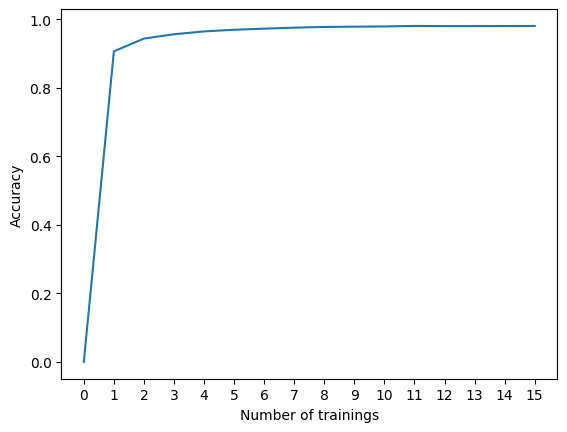

--- NEW MODEL 6 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([196, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([196])
Matrix3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 196])
Matrix3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Checking accuracy on test data
Got 8770 / 10000 with accuracy 87.70%
Row: 1 | [0, 0.877]


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Checking accuracy on test data
Got 9346 / 10000 with accuracy 93.46%
Row: 2 | [0, 0.877, 0.9346]


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Checking accuracy on test data
Got 9510 / 10000 with accuracy 95.10%
Row: 3 | [0, 0.877, 0.9346, 0.951]


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Checking accuracy on test data
Got 9601 / 10000 with accuracy 96.01%
Row: 4 | [0, 0.877, 0.9346, 0.951, 0.9601]


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Checking accuracy on test data
Got 9648 / 10000 with accuracy 96.48%
Row: 5 | [0, 0.877, 0.9346, 0.951, 0.9601, 0.9648]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 9690 / 10000 with accuracy 96.90%
Row: 6 | [0, 0.877, 0.9346, 0.951, 0.9601, 0.9648, 0.969]


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Checking accuracy on test data
Got 9717 / 10000 with accuracy 97.17%
Row: 7 | [0, 0.877, 0.9346, 0.951, 0.9601, 0.9648, 0.969, 0.9717]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 9728 / 10000 with accuracy 97.28%
Row: 8 | [0, 0.877, 0.9346, 0.951, 0.9601, 0.9648, 0.969, 0.9717, 0.9728]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 9740 / 10000 with accuracy 97.40%
Row: 9 | [0, 0.877, 0.9346, 0.951, 0.9601, 0.9648, 0.969, 0.9717, 0.9728, 0.974]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 9747 / 10000 with accuracy 97.47%
Row: 10 | [0, 0.877, 0.9346, 0.951, 0.9601, 0.9648, 0.969, 0.9717, 0.9728, 0.974, 0.9747]


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Checking accuracy on test data
Got 9765 / 10000 with accuracy 97.65%
Row: 11 | [0, 0.877, 0.9346, 0.951, 0.9601, 0.9648, 0.969, 0.9717, 0.9728, 0.974, 0.9747, 0.9765]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 9764 / 10000 with accuracy 97.64%
Row: 12 | [0, 0.877, 0.9346, 0.951, 0.9601, 0.9648, 0.969, 0.9717, 0.9728, 0.974, 0.9747, 0.9765, 0.9764]


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Checking accuracy on test data
Got 9773 / 10000 with accuracy 97.73%
Row: 13 | [0, 0.877, 0.9346, 0.951, 0.9601, 0.9648, 0.969, 0.9717, 0.9728, 0.974, 0.9747, 0.9765, 0.9764, 0.9773]


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Checking accuracy on test data
Got 9779 / 10000 with accuracy 97.79%
Row: 14 | [0, 0.877, 0.9346, 0.951, 0.9601, 0.9648, 0.969, 0.9717, 0.9728, 0.974, 0.9747, 0.9765, 0.9764, 0.9773, 0.9779]


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Checking accuracy on test data
Got 9774 / 10000 with accuracy 97.74%
Row: 15 | [0, 0.877, 0.9346, 0.951, 0.9601, 0.9648, 0.969, 0.9717, 0.9728, 0.974, 0.9747, 0.9765, 0.9764, 0.9773, 0.9779, 0.9774]


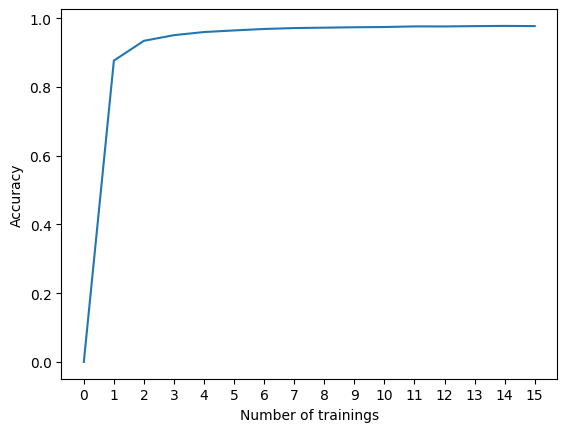

--- NEW MODEL 7 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([196, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([196])
Matrix3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 196])
Matrix3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 7459 / 10000 with accuracy 74.59%
Row: 1 | [0, 0.7459]


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Checking accuracy on test data
Got 7676 / 10000 with accuracy 76.76%
Row: 2 | [0, 0.7459, 0.7676]


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Checking accuracy on test data
Got 7776 / 10000 with accuracy 77.76%
Row: 3 | [0, 0.7459, 0.7676, 0.7776]


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Checking accuracy on test data
Got 7826 / 10000 with accuracy 78.26%
Row: 4 | [0, 0.7459, 0.7676, 0.7776, 0.7826]


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Checking accuracy on test data
Got 7851 / 10000 with accuracy 78.51%
Row: 5 | [0, 0.7459, 0.7676, 0.7776, 0.7826, 0.7851]


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Checking accuracy on test data
Got 7886 / 10000 with accuracy 78.86%
Row: 6 | [0, 0.7459, 0.7676, 0.7776, 0.7826, 0.7851, 0.7886]


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Checking accuracy on test data
Got 7894 / 10000 with accuracy 78.94%
Row: 7 | [0, 0.7459, 0.7676, 0.7776, 0.7826, 0.7851, 0.7886, 0.7894]


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Checking accuracy on test data
Got 7906 / 10000 with accuracy 79.06%
Row: 8 | [0, 0.7459, 0.7676, 0.7776, 0.7826, 0.7851, 0.7886, 0.7894, 0.7906]


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Checking accuracy on test data
Got 7910 / 10000 with accuracy 79.10%
Row: 9 | [0, 0.7459, 0.7676, 0.7776, 0.7826, 0.7851, 0.7886, 0.7894, 0.7906, 0.791]


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Checking accuracy on test data
Got 7915 / 10000 with accuracy 79.15%
Row: 10 | [0, 0.7459, 0.7676, 0.7776, 0.7826, 0.7851, 0.7886, 0.7894, 0.7906, 0.791, 0.7915]


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Checking accuracy on test data
Got 7914 / 10000 with accuracy 79.14%
Row: 11 | [0, 0.7459, 0.7676, 0.7776, 0.7826, 0.7851, 0.7886, 0.7894, 0.7906, 0.791, 0.7915, 0.7914]


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Checking accuracy on test data
Got 7920 / 10000 with accuracy 79.20%
Row: 12 | [0, 0.7459, 0.7676, 0.7776, 0.7826, 0.7851, 0.7886, 0.7894, 0.7906, 0.791, 0.7915, 0.7914, 0.792]


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Checking accuracy on test data
Got 7926 / 10000 with accuracy 79.26%
Row: 13 | [0, 0.7459, 0.7676, 0.7776, 0.7826, 0.7851, 0.7886, 0.7894, 0.7906, 0.791, 0.7915, 0.7914, 0.792, 0.7926]


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Checking accuracy on test data
Got 7932 / 10000 with accuracy 79.32%
Row: 14 | [0, 0.7459, 0.7676, 0.7776, 0.7826, 0.7851, 0.7886, 0.7894, 0.7906, 0.791, 0.7915, 0.7914, 0.792, 0.7926, 0.7932]


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Checking accuracy on test data
Got 7929 / 10000 with accuracy 79.29%
Row: 15 | [0, 0.7459, 0.7676, 0.7776, 0.7826, 0.7851, 0.7886, 0.7894, 0.7906, 0.791, 0.7915, 0.7914, 0.792, 0.7926, 0.7932, 0.7929]


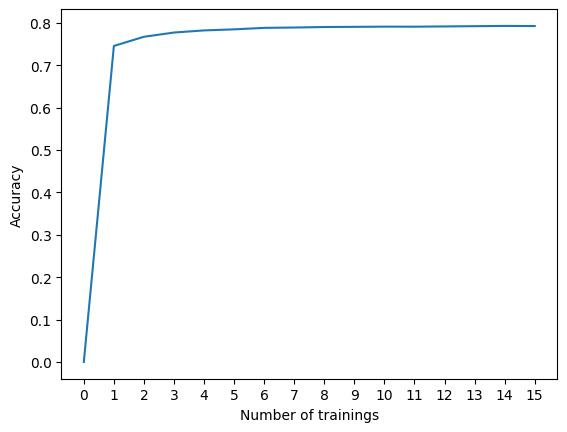

--- NEW MODEL 8 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([196, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([196])
Matrix3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 196])
Matrix3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Checking accuracy on test data
Got 8206 / 10000 with accuracy 82.06%
Row: 1 | [0, 0.8206]


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Checking accuracy on test data
Got 8500 / 10000 with accuracy 85.00%
Row: 2 | [0, 0.8206, 0.85]


100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Checking accuracy on test data
Got 8627 / 10000 with accuracy 86.27%
Row: 3 | [0, 0.8206, 0.85, 0.8627]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 8685 / 10000 with accuracy 86.85%
Row: 4 | [0, 0.8206, 0.85, 0.8627, 0.8685]


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Checking accuracy on test data
Got 8720 / 10000 with accuracy 87.20%
Row: 5 | [0, 0.8206, 0.85, 0.8627, 0.8685, 0.872]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 8751 / 10000 with accuracy 87.51%
Row: 6 | [0, 0.8206, 0.85, 0.8627, 0.8685, 0.872, 0.8751]


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Checking accuracy on test data
Got 8772 / 10000 with accuracy 87.72%
Row: 7 | [0, 0.8206, 0.85, 0.8627, 0.8685, 0.872, 0.8751, 0.8772]


100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Checking accuracy on test data
Got 8787 / 10000 with accuracy 87.87%
Row: 8 | [0, 0.8206, 0.85, 0.8627, 0.8685, 0.872, 0.8751, 0.8772, 0.8787]


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Checking accuracy on test data
Got 8795 / 10000 with accuracy 87.95%
Row: 9 | [0, 0.8206, 0.85, 0.8627, 0.8685, 0.872, 0.8751, 0.8772, 0.8787, 0.8795]


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Checking accuracy on test data
Got 8804 / 10000 with accuracy 88.04%
Row: 10 | [0, 0.8206, 0.85, 0.8627, 0.8685, 0.872, 0.8751, 0.8772, 0.8787, 0.8795, 0.8804]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 8812 / 10000 with accuracy 88.12%
Row: 11 | [0, 0.8206, 0.85, 0.8627, 0.8685, 0.872, 0.8751, 0.8772, 0.8787, 0.8795, 0.8804, 0.8812]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 8821 / 10000 with accuracy 88.21%
Row: 12 | [0, 0.8206, 0.85, 0.8627, 0.8685, 0.872, 0.8751, 0.8772, 0.8787, 0.8795, 0.8804, 0.8812, 0.8821]


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Checking accuracy on test data
Got 8819 / 10000 with accuracy 88.19%
Row: 13 | [0, 0.8206, 0.85, 0.8627, 0.8685, 0.872, 0.8751, 0.8772, 0.8787, 0.8795, 0.8804, 0.8812, 0.8821, 0.8819]


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Checking accuracy on test data
Got 8829 / 10000 with accuracy 88.29%
Row: 14 | [0, 0.8206, 0.85, 0.8627, 0.8685, 0.872, 0.8751, 0.8772, 0.8787, 0.8795, 0.8804, 0.8812, 0.8821, 0.8819, 0.8829]


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Checking accuracy on test data
Got 8830 / 10000 with accuracy 88.30%
Row: 15 | [0, 0.8206, 0.85, 0.8627, 0.8685, 0.872, 0.8751, 0.8772, 0.8787, 0.8795, 0.8804, 0.8812, 0.8821, 0.8819, 0.8829, 0.883]


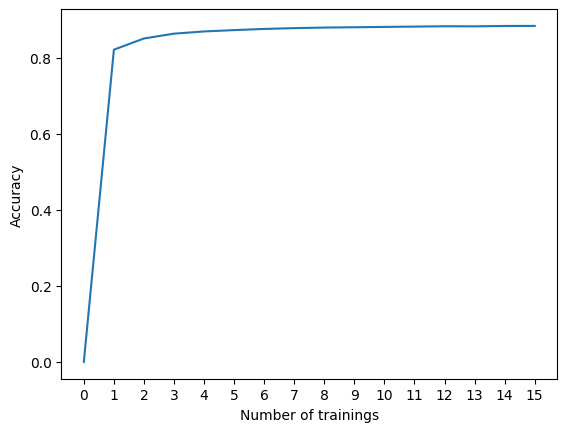

--- NEW MODEL 9 --- 
Matrix1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
Matrix1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
Matrix2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([196, 392])
Matrix2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([196])
Matrix3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 196])
Matrix3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 8980 / 10000 with accuracy 89.80%
Row: 1 | [0, 0.898]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 9366 / 10000 with accuracy 93.66%
Row: 2 | [0, 0.898, 0.9366]


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Checking accuracy on test data
Got 9530 / 10000 with accuracy 95.30%
Row: 3 | [0, 0.898, 0.9366, 0.953]


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Checking accuracy on test data
Got 9607 / 10000 with accuracy 96.07%
Row: 4 | [0, 0.898, 0.9366, 0.953, 0.9607]


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Checking accuracy on test data
Got 9665 / 10000 with accuracy 96.65%
Row: 5 | [0, 0.898, 0.9366, 0.953, 0.9607, 0.9665]


100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Checking accuracy on test data
Got 9710 / 10000 with accuracy 97.10%
Row: 6 | [0, 0.898, 0.9366, 0.953, 0.9607, 0.9665, 0.971]


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Checking accuracy on test data
Got 9724 / 10000 with accuracy 97.24%
Row: 7 | [0, 0.898, 0.9366, 0.953, 0.9607, 0.9665, 0.971, 0.9724]


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Checking accuracy on test data
Got 9741 / 10000 with accuracy 97.41%
Row: 8 | [0, 0.898, 0.9366, 0.953, 0.9607, 0.9665, 0.971, 0.9724, 0.9741]


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Checking accuracy on test data
Got 9762 / 10000 with accuracy 97.62%
Row: 9 | [0, 0.898, 0.9366, 0.953, 0.9607, 0.9665, 0.971, 0.9724, 0.9741, 0.9762]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 9771 / 10000 with accuracy 97.71%
Row: 10 | [0, 0.898, 0.9366, 0.953, 0.9607, 0.9665, 0.971, 0.9724, 0.9741, 0.9762, 0.9771]


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Checking accuracy on test data
Got 9767 / 10000 with accuracy 97.67%
Row: 11 | [0, 0.898, 0.9366, 0.953, 0.9607, 0.9665, 0.971, 0.9724, 0.9741, 0.9762, 0.9771, 0.9767]


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Checking accuracy on test data
Got 9777 / 10000 with accuracy 97.77%
Row: 12 | [0, 0.898, 0.9366, 0.953, 0.9607, 0.9665, 0.971, 0.9724, 0.9741, 0.9762, 0.9771, 0.9767, 0.9777]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Checking accuracy on test data
Got 9789 / 10000 with accuracy 97.89%
Row: 13 | [0, 0.898, 0.9366, 0.953, 0.9607, 0.9665, 0.971, 0.9724, 0.9741, 0.9762, 0.9771, 0.9767, 0.9777, 0.9789]


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Checking accuracy on test data
Got 9789 / 10000 with accuracy 97.89%
Row: 14 | [0, 0.898, 0.9366, 0.953, 0.9607, 0.9665, 0.971, 0.9724, 0.9741, 0.9762, 0.9771, 0.9767, 0.9777, 0.9789, 0.9789]


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Checking accuracy on test data
Got 9785 / 10000 with accuracy 97.85%
Row: 15 | [0, 0.898, 0.9366, 0.953, 0.9607, 0.9665, 0.971, 0.9724, 0.9741, 0.9762, 0.9771, 0.9767, 0.9777, 0.9789, 0.9789, 0.9785]


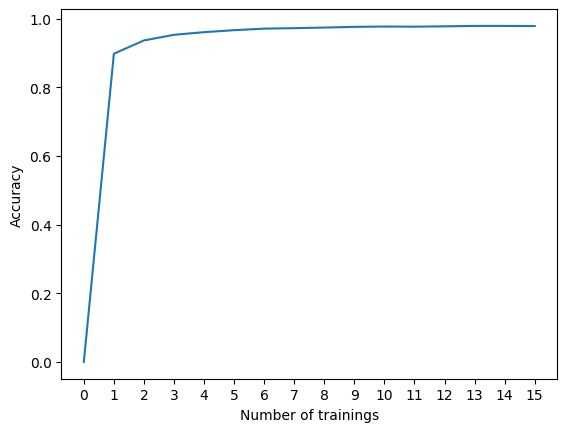

Test 0: [0, 0.8005, 0.8428, 0.855, 0.8648, 0.8716, 0.8751, 0.8773, 0.8791, 0.8801, 0.8819, 0.8824, 0.8845, 0.8834, 0.8844, 0.8843]
Test 1: [0, 0.7446, 0.7656, 0.7763, 0.7824, 0.7845, 0.7863, 0.7873, 0.7881, 0.7885, 0.7881, 0.7883, 0.7885, 0.7888, 0.7885, 0.7895]
Test 2: [0, 0.9168, 0.9452, 0.958, 0.965, 0.9701, 0.9719, 0.9744, 0.9766, 0.9774, 0.9786, 0.9786, 0.9791, 0.9791, 0.9796, 0.9798]
Test 3: [0, 0.9177, 0.9457, 0.9583, 0.965, 0.9698, 0.973, 0.9754, 0.9762, 0.978, 0.9777, 0.9786, 0.9786, 0.9784, 0.979, 0.9788]
Test 4: [0, 0.9044, 0.9397, 0.9551, 0.9628, 0.967, 0.9703, 0.9729, 0.9758, 0.9762, 0.9769, 0.977, 0.9779, 0.9779, 0.978, 0.9789]
Test 5: [0, 0.9062, 0.9434, 0.956, 0.9643, 0.9691, 0.9723, 0.9752, 0.9773, 0.9781, 0.9788, 0.9803, 0.9798, 0.9798, 0.9801, 0.9802]
Test 6: [0, 0.877, 0.9346, 0.951, 0.9601, 0.9648, 0.969, 0.9717, 0.9728, 0.974, 0.9747, 0.9765, 0.9764, 0.9773, 0.9779, 0.9774]
Test 7: [0, 0.7459, 0.7676, 0.7776, 0.7826, 0.7851, 0.7886, 0.7894, 0.7906, 0.791, 0.7915, 

In [9]:
num_trainings = 15
num_trials = 10

acc_dict = {}
acc_dict[0] = 0

data = {}

# Loop through number of trials
for trial in range(num_trials):
  print(f"--- NEW MODEL {trial} --- ")
  data[trial] = run_trials(num_trainings)

# Print data after all runs
for i in range(num_trials):
  print(f"Test {i}: {data[i]}")


         0       1       2       3       4       5       6       7       8  \
0   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1   0.8005  0.7446  0.9168  0.9177  0.9044  0.9062  0.8770  0.7459  0.8206   
2   0.8428  0.7656  0.9452  0.9457  0.9397  0.9434  0.9346  0.7676  0.8500   
3   0.8550  0.7763  0.9580  0.9583  0.9551  0.9560  0.9510  0.7776  0.8627   
4   0.8648  0.7824  0.9650  0.9650  0.9628  0.9643  0.9601  0.7826  0.8685   
5   0.8716  0.7845  0.9701  0.9698  0.9670  0.9691  0.9648  0.7851  0.8720   
6   0.8751  0.7863  0.9719  0.9730  0.9703  0.9723  0.9690  0.7886  0.8751   
7   0.8773  0.7873  0.9744  0.9754  0.9729  0.9752  0.9717  0.7894  0.8772   
8   0.8791  0.7881  0.9766  0.9762  0.9758  0.9773  0.9728  0.7906  0.8787   
9   0.8801  0.7885  0.9774  0.9780  0.9762  0.9781  0.9740  0.7910  0.8795   
10  0.8819  0.7881  0.9786  0.9777  0.9769  0.9788  0.9747  0.7915  0.8804   
11  0.8824  0.7883  0.9786  0.9786  0.9770  0.9803  0.9765  0.79

<ErrorbarContainer object of 3 artists>

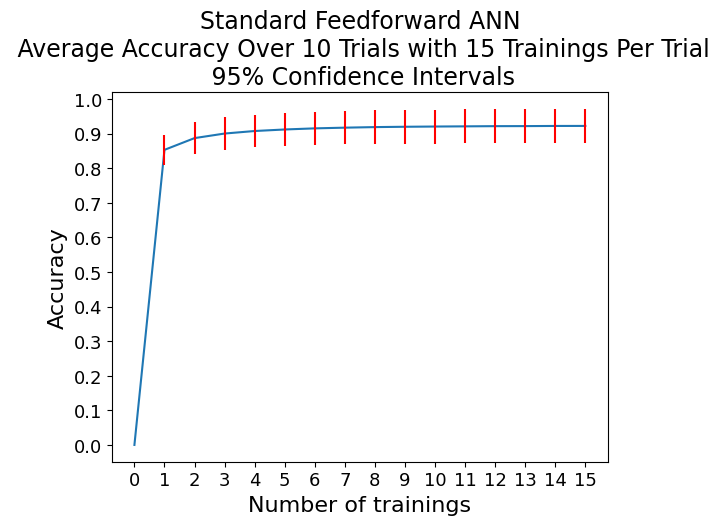

In [10]:
# Convert list of data over tests into a data frame
df = pd.DataFrame(data)
print(df)

x_values = list(range(len(df)))
trial_idx_list = list(range(num_trials))

ci_values = []

# Calculate the mean accuracy for each training per trial
mean_values = df[trial_idx_list].mean(axis=1).tolist()

# Calculate confidence intervals for each training
for _, row in df[trial_idx_list].iterrows():
  mean = row.mean()
  sem = row.sem()
  ci = sem * 1.96  # 95% confidence interval
  ci_values.append(ci)

plt.title(f"Standard Feedforward ANN\n Average Accuracy Over {num_trials} Trials with {num_trainings} Trainings Per Trial\n 95% Confidence Intervals", fontsize = 17)
plt.xlabel("Number of trainings", fontsize = 16)
plt.ylabel("Accuracy", fontsize = 16)
plt.xticks(np.arange(0, num_trainings + 1, 1), fontsize = 13)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize = 13)

sns.lineplot(x = x_values, y = mean_values)
plt.errorbar(x = x_values, y = mean_values, yerr=ci_values, linestyle='None', color='red')